## 0. Configurations

In [1]:
# ====================================================================
# Configuration ÏÑ§Ï†ï
# ====================================================================
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Î∞è Í≤ΩÎ°ú Îì± Ïã§ÌóòÏóê ÌïÑÏöîÌïú ÏÑ§Ï†ïÎì§ÏùÑ Î™®ÏïÑÎë†
# Ïã§Ìóò Ï∂îÏ†Å Î∞è Ïû¨ÌòÑÏÑ±ÏùÑ ÏúÑÌï¥ Î™®Îì† Í∞íÏùÄ Ïó¨Í∏∞ÏóêÏÑú ÏàòÏ†ïÌïòÍ≥†Ïûê Ìï®
import os  # ÎîîÎ†âÌÜ†Î¶¨, ÌååÏùº Í≤ΩÎ°ú Ï°∞Ïûë Îì±

import torch
import numpy as np

from pathlib import Path

import albumentations as A
import cv2  # OpenCV - Í≥†Í∏â Ïù¥ÎØ∏ÏßÄ/ÎπÑÎîîÏò§ Ï≤òÎ¶¨
import torch
from torch.utils.data import Dataset  # Ïª§Ïä§ÌÖÄ Îç∞Ïù¥ÌÑ∞ÏÖã, Î∞∞Ïπò Î°úÎî©
import pandas as pd
from collections import defaultdict, Counter
import os
import json
from tqdm import tqdm
import shutil # ÌååÏùº Î≥µÏÇ¨/Ïù¥Îèô
from PIL import Image
from sklearn.model_selection import train_test_split
import random

# YOLOv8 ÎùºÏù¥Î∏åÎü¨Î¶¨
from ultralytics import YOLO

# yaml ÎùºÏù¥Î∏åÎü¨Î¶¨
import yaml 

# Garbage Collector Î™®Îìà
import gc

from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ÏãúÍ∞ÅÌôî ÎèÑÍµ¨
import matplotlib.pyplot as plt  # Í∏∞Î≥∏ ÏãúÍ∞ÅÌôî
import matplotlib
# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (WindowsÏùò Í∏∞Î≥∏ ÌïúÍ∏Ä Ìè∞Ìä∏)
matplotlib.rc('font', family='Malgun Gothic')
# ÎßàÏù¥ÎÑàÏä§ Íπ®Ïßê Î∞©ÏßÄ
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as patches

# Ï£ºÌîºÌÑ∞ ÎÖ∏Ìä∏Î∂ÅÏóêÏÑú Ïù¥ÎØ∏ÏßÄ Ïù∏ÎùºÏù∏ ÌëúÏãúÎ•º ÏúÑÌïú Îß§ÏßÅ Î™ÖÎ†πÏñ¥ Ï∂îÍ∞Ä (Ïó¨Í∏∞ Ï∂îÍ∞Ä)
%matplotlib inline

# Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ Î£®Ìã¥
gc.collect()
torch.cuda.empty_cache()


# --- ÎîîÎ∞îÏù¥Ïä§ ÏÑ§Ï†ï ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

# --- ÌïôÏäµ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ---
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# --- Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏÑ§Ï†ï ---
# DATA_ROOT = path
# DATA_ROOT = "data/raw/ai03-level1-project/"  # Í≤ΩÎ°ú
# TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train_images")
# TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, "train_annotations")
# TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test_images")
# PROCESSED_TRAIN_CSV = "../data/processed/train_df.csv"  # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Îêú csv ÌååÏùº

# --- Î™®Îç∏ ÏÑ§Ï†ï ---
NUM_CLASSES = 73
MODEL_NAME = "fasterrcnn_resnet50_fpn"
USE_PRETRAINED = True

# --- ÌïôÏäµ Í≥†ÎèÑÌôî ÏÑ§Ï†ï ---
USE_SCHEDULER = True  # Learning rate scheduler ÏÇ¨Ïö© Ïó¨Î∂Ä
EARLY_STOPPING = True  # Early stopping Ï†ÅÏö© Ïó¨Î∂Ä
AUGMENTATION = True  # Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏÇ¨Ïö© Ïó¨Î∂Ä

# --- Ïã§Ìóò Î°úÍπÖÏö© ÏÑ§Ï†ï ---
USE_WANDB = True
WANDB_PROJECT = "AI03-Project-1"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"


# --- Ïã§Ìóò Í≤∞Í≥º Ï†ÄÏû• Í≤ΩÎ°ú ---
EXPERIMENT_DIR = "../experiments"

## 1. Data-preprocessing

### Fast-rcnn

In [2]:
def parse_raw_annotations(ann_dir: Path) -> pd.DataFrame:
    """
    Î≥µÏû°Ìïú 3Ï§ë Ìè¥Îçî Íµ¨Ï°∞Ïùò ÏõêÎ≥∏ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ ÌååÏã±ÌïòÏó¨
    ÌïòÎÇòÏùò Pandas DataFrameÏúºÎ°ú Î∞òÌôòÌïòÎäî Ìï®Ïàò.
    """
    all_annotations = []

    # Level 1: Ïù¥ÎØ∏ÏßÄÎ≥Ñ Ìè¥Îçî ÏàúÌöå
    image_level_dirs = os.listdir(ann_dir)
    for image_dir_name in tqdm(image_level_dirs, desc="[L1] Images"):
        image_dir_path = ann_dir / image_dir_name
        if not image_dir_path.is_dir():
            continue

        # Level 2: ÏïåÏïΩ Ï¢ÖÎ•ò Ìè¥Îçî ÏàúÌöå
        pill_level_dirs = os.listdir(image_dir_path)
        for pill_dir_name in pill_level_dirs:
            pill_dir_path = image_dir_path / pill_dir_name
            if not pill_dir_path.is_dir():
                continue

            # Level 3: Ïã§Ï†ú .json ÌååÏùº ÌååÏã±
            json_files = [f for f in os.listdir(pill_dir_path) if f.endswith(".json")]
            if not json_files:
                continue

            # Ï≤´ Î≤àÏß∏ json ÌååÏùºÎßå ÏÇ¨Ïö©
            json_file_path = pill_dir_path / json_files[0]

            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    ann_data = json.load(f)

                    image_info = ann_data.get("images", [{}])[0]
                    annotation_info = ann_data.get("annotations", [{}])[0]
                    category_info = ann_data.get("categories", [{}])[0]

                    all_annotations.append(
                        {
                            "image_id": image_info.get("id"),
                            "file_name": image_info.get("file_name"),
                            "width": image_info.get("width"),
                            "height": image_info.get("height"),
                            "category_id": category_info.get("id"),
                            "class_name": category_info.get("name"),
                            "bbox": annotation_info.get("bbox"),
                        }
                    )
            except Exception as e:
                print(f"\nÌååÏùº Ï≤òÎ¶¨ ÏóêÎü¨: {json_file_path}, ÏóêÎü¨: {e}")

    return pd.DataFrame(all_annotations)

In [3]:
# 1. ÌïµÏã¨ Ìï®ÏàòÎ•º Ìò∏Ï∂úÌï¥ÏÑú DataFrame ÏÉùÏÑ±

BASE_DIR = Path("../")  # ÏÉÅÎåÄÍ≤ΩÎ°ú
RAW_DATA_DIR = BASE_DIR / "data/raw/"
PROCESSED_DATA_DIR = BASE_DIR / "data/processed"

TRAIN_IMAGE_DIR = RAW_DATA_DIR / "train_images"
TRAIN_ANNO_DIR = RAW_DATA_DIR / "train_annotations"
TEST_IMAGE_DIR = RAW_DATA_DIR / "test_images"
SAVE_PATH = PROCESSED_DATA_DIR / "train_df.csv"
train_df = parse_raw_annotations(TRAIN_ANNO_DIR)

# --- (1). bbox Ïª¨ÎüºÏùÑ 4Í∞úÎ°ú Î∂ÑÎ¶¨ ---
# bbox Ïª¨Îüº Î∂ÑÎ¶¨
bbox_df = pd.DataFrame(
    train_df["bbox"].tolist(), columns=["bbox_x", "bbox_y", "bbox_w", "bbox_h"]
)
train_df = pd.concat([train_df.drop("bbox", axis=1), bbox_df], axis=1)

# ‚ú® --- [ÌïµÏã¨ ÏàòÏ†ï] ÏûòÎ™ªÎêú Î∞îÏö¥Îî© Î∞ïÏä§ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞ ---
# xmax (bbox_x + bbox_w)Í∞Ä Ïù¥ÎØ∏ÏßÄ ÎÑàÎπÑ(width)Î•º Ï¥àÍ≥ºÌïòÎäî Í≤ΩÏö∞
invalid_x = train_df["bbox_x"] + train_df["bbox_w"] > train_df["width"]
# ymax (bbox_y + bbox_h)Í∞Ä Ïù¥ÎØ∏ÏßÄ ÎÜíÏù¥(height)Î•º Ï¥àÍ≥ºÌïòÎäî Í≤ΩÏö∞
invalid_y = train_df["bbox_y"] + train_df["bbox_h"] > train_df["height"]

# ÏûòÎ™ªÎêú Îç∞Ïù¥ÌÑ∞Î•º ÌïÑÌÑ∞ÎßÅ
invalid_rows = train_df[invalid_x | invalid_y]
if not invalid_rows.empty:
    print(f"--- {len(invalid_rows)}Í∞úÏùò ÏûòÎ™ªÎêú Î∞îÏö¥Îî© Î∞ïÏä§ Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏïòÏäµÎãàÎã§. ---")
    print(
        invalid_rows[
            ["file_name", "width", "height", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]
        ]
    )

    # Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞Îßå ÎÇ®ÍπÄ
    train_df = train_df[~(invalid_x | invalid_y)]
    print(f"\nÏûòÎ™ªÎêú Îç∞Ïù¥ÌÑ∞Î•º Ï†úÍ±∞ÌïòÍ≥†, {len(train_df)}Í∞úÏùò Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©Ìï©ÎãàÎã§.")

# --- (2). category_idÎ•º ÏÉàÎ°úÏö¥ label_idxÎ°ú Îß§Ìïë ---
# Í≥†Ïú†Ìïú category_id Î™©Î°ùÏùÑ ÎΩëÏïÑ Ï†ïÎ†¨
unique_category_ids = sorted(train_df["category_id"].unique())
NUM_CLASSES = len(unique_category_ids)
# category_idÎ•º 0, 1, 2... Ïù∏Îç±Ïä§Î°ú Î≥ÄÌôòÌïòÎäî ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
id_to_idx = {
    int(original_id): idx
    for idx, original_id in enumerate(
        unique_category_ids, start=1
    )  # <--- start=1 Ï∂îÍ∞Ä!
}
# Ïù¥ Îß§Ìïë Ï†ïÎ≥¥Î•º ÏÇ¨Ïö©Ìï¥ÏÑú 'label_idx'ÎùºÎäî ÏÉà Ïª¨ÎüºÏùÑ Ï∂îÍ∞Ä
train_df["label_idx"] = train_df["category_id"].map(id_to_idx)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)


# ÎÇòÏ§ëÏóê Ï∂îÎ°† Í≤∞Í≥ºÏóêÏÑú ÏõêÎûò ÌÅ¥ÎûòÏä§ Ïù¥Î¶ÑÏùÑ Ï∞æÏùÑ Ïàò ÏûàÎèÑÎ°ù Îß§Ìïë Ï†ïÎ≥¥ÎèÑ Ï†ÄÏû•
label_map = {
    "id_to_idx": id_to_idx,
    "idx_to_id": {idx: int(original_id) for original_id, idx in id_to_idx.items()},
    "id_to_name": dict(zip(train_df["category_id"], train_df["class_name"])),
}
with open(PROCESSED_DATA_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)

print(f"\nÏ¥ù {len(unique_category_ids)}Í∞úÏùò Í≥†Ïú† ÌÅ¥ÎûòÏä§Î•º Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.")
print("ÎùºÎ≤® Îß§Ìïë Ï†ïÎ≥¥Î•º 'data/processed/label_map.json'Ïóê Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")


# 3. ÏµúÏ¢Ö DataFrameÏùÑ CSV ÌååÏùºÎ°ú Ï†ÄÏû•
train_df.to_csv(SAVE_PATH, index=False)

print(f"\n--- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû• ÏôÑÎ£å! ---")
print(train_df.head())

[L1] Images: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 498/498 [00:00<00:00, 592.40it/s]

--- 1Í∞úÏùò ÏûòÎ™ªÎêú Î∞îÏö¥Îî© Î∞ïÏä§ Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏïòÏäµÎãàÎã§. ---
                                              file_name  width  height  \
1721  K-003544-004543-012247-016551_0_2_0_2_70_000_2...    976    1280   

      bbox_x  bbox_y  bbox_w  bbox_h  
1721     653    8889     217     217  

ÏûòÎ™ªÎêú Îç∞Ïù¥ÌÑ∞Î•º Ï†úÍ±∞ÌïòÍ≥†, 1875Í∞úÏùò Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©Ìï©ÎãàÎã§.

Ï¥ù 73Í∞úÏùò Í≥†Ïú† ÌÅ¥ÎûòÏä§Î•º Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.
ÎùºÎ≤® Îß§Ìïë Ï†ïÎ≥¥Î•º 'data/processed/label_map.json'Ïóê Ï†ÄÏû•ÌñàÏäµÎãàÎã§.

--- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû• ÏôÑÎ£å! ---
   image_id                                          file_name  width  height  \
0      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
1      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
2      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
3       411  K-001900-010224-016551-033009_0_2_0_2_70_000_2...    976    1280   
4       409  K-001900-010224-016551

<Axes: xlabel='label_idx'>

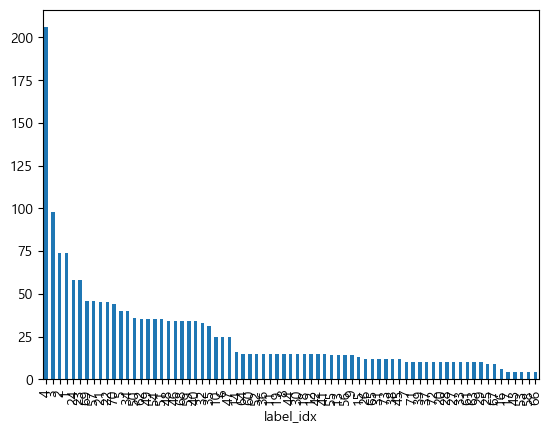

In [4]:
train_df["label_idx"].value_counts().plot(kind="bar")

In [5]:
train_df["class_name"].value_counts()

class_name
Í∏∞ÎÑ•Ïã†ÏóêÌîÑÏ†ï(ÏùÄÌñâÏóΩÏóëÏä§)(ÏàòÏ∂úÏö©)    206
ÏùºÏñëÌïòÏù¥Ìä∏Î¶∞Ï†ï 2mg            98
ÎÆ§ÌÖåÎûÄÏ∫°Ïäê 100mg            74
Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg             74
ÎèôÏïÑÍ∞ÄÎ∞îÌéúÌã¥Ï†ï 800mg          58
                     ... 
ÏûêÏù¥ÌîÑÎ†âÏÇ¨Ï†ï 2.5mg            4
Ïø†ÏóêÌÉÄÌïÄÏ†ï 25mg              4
Ï°∏Î°úÌë∏Ìä∏Ï†ï 100mg             4
Î†âÏÇ¨ÌîÑÎ°úÏ†ï 15mg              4
Î∏åÎ¶∞ÌÖîÎ¶≠Ïä§Ï†ï 20mg             4
Name: count, Length: 73, dtype: int64

In [6]:
classes_tmp = train_df["class_name"].unique()
classes_tmp

array(['Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg', 'ÎèôÏïÑÍ∞ÄÎ∞îÌéúÌã¥Ï†ï 800mg', 'ÎÇôÏÜåÏ°∏Ï†ï 500/20mg', 'Ïã†Î∞îÎ°úÏ†ï', 'Í∞ÄÎ∞îÌÜ†ÌååÏ†ï 100mg', 'ÎûÄÏä§ÌÜ§ÏóòÏóêÌîÑÎîîÌã∞Ï†ï 30mg', 'Ìé†Î£®ÎπÑÏ†ï(Ìé†Î£®ÎπÑÌîÑÎ°úÌéú)', 'Ïö∏Ìä∏ÎùºÏÖãÏù¥ÏïåÏÑúÎ∞©Ï†ï', 'ÎπÑÎ™®Î≥¥Ï†ï 500/20mg', 'Î†àÏùºÎùºÏ†ï', 'Ïä§ÌÜ†Í∞ÄÏ†ï 10mg', 'ÎùºÎπÑÏóêÌä∏Ï†ï 20mg', 'ÎÜÄÌÖçÏ†ï 10mg', 'ÏóêÏä§ÏõêÏó†ÌîÑÏ†ï 20mg', 'ÏºÄÏù¥Ï∫°Ï†ï 50mg', 'ÎÆ§ÌÖåÎûÄÏ∫°Ïäê 100mg', 'ÏïåÎìúÎ¶∞Ï†ï', 'ÌÉÄÏù¥Î†àÎÜÄÏ†ï500mg', 'ÏÇêÏΩ§Ïî®ÏóêÌîÑÏ†ï 618.6mg/Î≥ë', 'Îã§Î≥¥ÌÉÄÎØºÌÅêÏ†ï 10mg/Î≥ë', 'Ìä∏Î£®ÎπÑÌÉÄÏ†ï 60mg/Î≥ë',
       'Î©îÍ∞ÄÌååÏõåÏ†ï 90mg/Î≥ë', 'ÎπÑÌÉÄÎπÑÎ∞±Ï†ï 100mg/Î≥ë', 'ÌÉÄÏù¥Î†àÎÜÄÏù¥ÏïåÏÑúÎ∞©Ï†ï(ÏïÑÏÑ∏Ìä∏ÏïÑÎØ∏ÎÖ∏Ìéú)(ÏàòÏ∂úÏö©)', 'Î¶¨Î†âÏä§ÌéúÏ†ï 300mg/PTP', 'Ïç®Ïä§Ìéú8ÏãúÍ∞ÑÏù¥ÏïåÏÑúÎ∞©Ï†ï 650mg', 'Îß•ÏãúÎ∂ÄÌéúÏù¥ÏïåÏ†ï 300mg', 'ÏÇºÎÇ®Í±¥Ï°∞ÏàòÏÇ∞ÌôîÏïåÎ£®ÎØ∏ÎäÑÍ≤îÏ†ï', 'ÌÅêÏãúÎìúÏ†ï 31.5mg/PTP', 'ÏùºÏñëÌïòÏù¥Ìä∏Î¶∞Ï†ï 2mg', 'Îâ¥Î°úÎ©îÎìúÏ†ï(Ïò•ÏãúÎùºÏÑ∏ÌÉê)', 'Î¶¨ÌîºÌÜ†Ï†ï 20mg', 'ÌÅ¨Î†àÏä§ÌÜ†Ï†ï 20mg', 'Ïò§ÎßàÏΩîÏó∞ÏßàÏ∫°Ïäê(Ïò§Î©îÍ∞Ä-3-ÏÇ∞ÏóêÌã∏Ïóê

In [7]:
# 1. 'category_id'ÏôÄ 'class_name' Ïª¨ÎüºÏúºÎ°ú Í≥†Ïú†Ìïú ÏåçÏùÑ Ï∞æÍ≥†, ID Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
class_mapping_df = (
    train_df[["category_id", "class_name"]]
    .drop_duplicates()
    .sort_values(by="category_id")
)
# 2. Ï†ïÎ†¨Îêú DataFrameÏóêÏÑú ÌÅ¥ÎûòÏä§ Ïù¥Î¶ÑÎßå Î¶¨Ïä§Ìä∏Î°ú Ï∂îÏ∂ú
sorted_class_names = [
    name.split("(")[0].strip() for name in class_mapping_df["class_name"]
]
# 3. Îß® ÏïûÏóê 'background' Ï∂îÍ∞Ä
classes = ["background"] + sorted_class_names

print(f"Ï¥ù ÌÅ¥ÎûòÏä§ Í∞úÏàò (Î∞∞Í≤Ω Ìè¨Ìï®): {len(classes)}")
print(f"ÌÅ¥ÎûòÏä§ Î¶¨Ïä§Ìä∏: {classes}")

Ï¥ù ÌÅ¥ÎûòÏä§ Í∞úÏàò (Î∞∞Í≤Ω Ìè¨Ìï®): 74
ÌÅ¥ÎûòÏä§ Î¶¨Ïä§Ìä∏: ['background', 'Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg', 'ÎÆ§ÌÖåÎûÄÏ∫°Ïäê 100mg', 'ÏùºÏñëÌïòÏù¥Ìä∏Î¶∞Ï†ï 2mg', 'Í∏∞ÎÑ•Ïã†ÏóêÌîÑÏ†ï', 'Î¨¥ÏΩîÏä§ÌÉÄÏ†ï', 'ÏïåÎìúÎ¶∞Ï†ï', 'Îâ¥Î°úÎ©îÎìúÏ†ï', 'ÌÉÄÏù¥Î†àÎÜÄÏ†ï500mg', 'ÏóêÏñ¥ÌÉàÏ†ï', 'ÏÇºÎÇ®Í±¥Ï°∞ÏàòÏÇ∞ÌôîÏïåÎ£®ÎØ∏ÎäÑÍ≤îÏ†ï', 'ÌÉÄÏù¥Î†àÎÜÄÏù¥ÏïåÏÑúÎ∞©Ï†ï', 'ÏÇêÏΩ§Ïî®ÏóêÌîÑÏ†ï 618.6mg/Î≥ë', 'Ï°∞Ïù∏Ïä§Ï†ï 200mg', 'ÏéÑÎ°úÏºàÏ†ï 100mg', 'Î¶¨Î†âÏä§ÌéúÏ†ï 300mg/PTP', 'ÏïÑÎπåÎ¶¨ÌååÏù¥Ï†ï 10mg', 'ÏûêÏù¥ÌîÑÎ†âÏÇ¨Ï†ï 2.5mg', 'Îã§Î≥¥ÌÉÄÎØºÌÅêÏ†ï 10mg/Î≥ë', 'Ïç®Ïä§Ìéú8ÏãúÍ∞ÑÏù¥ÏïåÏÑúÎ∞©Ï†ï 650mg', 'ÏóêÎπÖÏÇ¨Ï†ï', 'Î¶¨ÌîºÌÜ†Ï†ï 20mg', 'ÌÅ¨Î†àÏä§ÌÜ†Ï†ï 20mg', 'Í∞ÄÎ∞îÌÜ†ÌååÏ†ï 100mg', 'ÎèôÏïÑÍ∞ÄÎ∞îÌéúÌã¥Ï†ï 800mg', 'Ïò§ÎßàÏΩîÏó∞ÏßàÏ∫°Ïäê', 'ÎûÄÏä§ÌÜ§ÏóòÏóêÌîÑÎîîÌã∞Ï†ï 30mg', 'Î¶¨Î¶¨Ïπ¥Ï∫°Ïäê 150mg', 'Ï¢ÖÍ∑ºÎãπÍ∏ÄÎ¶¨ÏïÑÌã∞Î¶∞Ïó∞ÏßàÏ∫°Ïäê', 'ÏΩúÎ¶¨ÎÑ§Ïù¥Ìä∏Ïó∞ÏßàÏ∫°Ïäê 400mg', 'Ìä∏Î£®ÎπÑÌÉÄÏ†ï 60mg/Î≥ë', 'Ïä§ÌÜ†Í∞ÄÏ†ï 10mg', 'ÎÖ∏Î∞îÏä§ÌÅ¨Ï†ï 5mg', 'ÎßàÎèÑÌååÏ†ï', 'ÌîåÎùºÎπÖÏä§Ï†ï 75mg', 'ÏóëÏä§Ìè¨ÏßÄÏ†ï 5/160mg', 

### Yolov8

In [8]:
PROJECT_ROOT = Path("../../AI03-Project-1")
DATA_ROOT = Path("../../AI03-Project-1/data/raw") # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°úÎ°ú Î≥ÄÍ≤Ω ÌïÑÏöî
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"

In [9]:
# YOLOv8 Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìï† ÏÉà ÎîîÎ†âÌÜ†Î¶¨
YOLO_DATA_ROOT = Path("../../AI03-Project-1/data") / "processed" / "yolov8_dataset"
YOLO_IMAGES_TRAIN = YOLO_DATA_ROOT / "images" / "train"
YOLO_LABELS_TRAIN = YOLO_DATA_ROOT / "labels" / "train"
YOLO_IMAGES_VAL = YOLO_DATA_ROOT / "images" / "val"
YOLO_LABELS_VAL = YOLO_DATA_ROOT / "labels" / "val"
YOLO_LABELS_TEMP = Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolo_labels_temp" # Î≥ÄÌôòÎêú .txt ÌååÏùºÏùÑ ÏûÑÏãúÎ°ú Ï†ÄÏû•Ìï† Í≥≥

In [10]:
# ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TEMP, exist_ok=True)

In [11]:
def create_yolo_annotations_and_map(annotation_root: Path, train_image_dir: Path, yolo_labels_output_dir: Path):
    """
    Ï†úÍ≥µÎêú Î≥µÏû°Ìïú JSON Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Ìè¥Îçî Íµ¨Ï°∞Î•º ÌååÏã±ÌïòÍ≥† YOLO ÌòïÏãù(.txt)ÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Ï†ÄÏû•Ìï©ÎãàÎã§.
    - train_images: Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎì§ (Ïòà: K-XXXXX_Y_Z.png)
    - train_annotations:
        - K-XXXXX_Y_Z_json/ (Ïù¥ÎØ∏ÏßÄ Í∑∏Î£π Ìè¥Îçî)
            - K-AAAAA/ (Í∞úÎ≥Ñ ÏïΩÏ†ú ID Ìè¥Îçî)
                - K-XXXXX_Y_Z.json (Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄ ÎÇ¥ K-AAAAA ÏïΩÏ†úÏùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò)

    Í∞Å Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏù¥ Ïó¨Îü¨ JSON ÌååÏùº(Í∞Å ÏïåÏïΩÎ≥Ñ)Ïóê Î∂ÑÏÇ∞ÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú
    JSON ÌååÏùºÎ™ÖÏù¥ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎ™ÖÍ≥º ÎèôÏùºÌïú ÌòïÌÉúÎ•º Ï≤òÎ¶¨Ìï©ÎãàÎã§.
    """
    
    category_id_to_name = {}
    
    # 1. Î™®Îì† JSON ÌååÏùºÏùÑ Ïä§Ï∫îÌïòÏó¨ category_id_to_name Îßµ ÏàòÏßë
    # Î™®Îì† JSON ÌååÏùºÏóêÏÑú ÌÅ¥ÎûòÏä§ Ï†ïÎ≥¥Î•º Ìïú Î≤àÏóê ÏàòÏßëÌï©ÎãàÎã§.
    all_json_paths_for_categories_scan = []
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith('.json'):
                all_json_paths_for_categories_scan.append(os.path.join(dirpath, fname))

    print(f"Scanning {len(all_json_paths_for_categories_scan)} JSON files to collect categories...")
    
    for json_path in tqdm(all_json_paths_for_categories_scan, desc="Collecting categories"):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if 'categories' in data:
                    for cat in data['categories']:
                        category_id_to_name[cat['id']] = cat['name']
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Warning: Could not parse categories from {json_path} due to {e}. Skipping.")
            continue

    sorted_category_ids = sorted(list(category_id_to_name.keys()))
    yolo_class_id_map = {cat_id: idx for idx, cat_id in enumerate(sorted_category_ids)}
    yolo_idx_to_name_map = {idx: category_id_to_name[cat_id] for cat_id, idx in yolo_class_id_map.items()}

    print(f"\nDetected {len(sorted_category_ids)} unique categories.")
    
    for cat_id in sorted_category_ids:
        print(f"  Original ID: {cat_id}, YOLO ID: {yolo_class_id_map[cat_id]}, Name: {category_id_to_name[cat_id]}")

    # 2. train_images Ìè¥ÎçîÏùò Î™®Îì† Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î™©Î°ùÏùÑ ÌôïÎ≥¥
    all_image_files_in_dir = []
    # Ïù¥ÎØ∏ÏßÄ ÌôïÏû•ÏûêÎì§ÏùÑ Ïú†Ïó∞ÌïòÍ≤å Ï≤òÎ¶¨
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']: 
        all_image_files_in_dir.extend(list(train_image_dir.glob(f"*{ext}")))
    all_image_files_in_dir = sorted(list(set(all_image_files_in_dir))) # Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Ï†ïÎ†¨
    
    print(f"\nFound {len(all_image_files_in_dir)} image files in {train_image_dir}")

    # YOLO ÎùºÎ≤®ÏùÑ Ï†ÄÏû•Ìï† ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
    yolo_labels_output_dir.mkdir(parents=True, exist_ok=True)

    annotations_info = defaultdict(dict) # Í∞Å Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú Ï†ïÎ≥¥Î•º Ï†ÄÏû•

    # 3. Í∞Å Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏóê ÎåÄÌï¥ Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÏùò Î™®Îì† ÏïåÏïΩ JSON Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Ï∞æÏïÑ YOLO ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
    processed_json_count = 0
    generated_yolo_labels_count = 0

    for img_path in tqdm(all_image_files_in_dir, desc="Processing images and consolidating annotations"):
        img_stem = img_path.stem # Ïòà: 'K-001900-010224-016551-031705_0_2_0_2_70_000_200'

        try:
            with Image.open(img_path) as img:
                img_w, img_h = img.size
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Skipping this image.")
            continue
        
        yolo_lines_for_this_image = []
        found_ann_for_current_image = False # ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌï¥ Ïú†Ìö®Ìïú Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Ï∞æÏïòÎäîÏßÄ Ïó¨Î∂Ä
        
        # annotation_root ÏïÑÎûòÏùò Î™®Îì† JSON ÌååÏùºÏùÑ Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú ÌÉêÏÉâ
        # JSON ÌååÏùºÎ™ÖÏù¥ ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄÏùò stemÍ≥º Ï†ïÌôïÌûà ÏùºÏπòÌïòÎäî ÌååÏùºÏùÑ Ï∞æÏùå
        for dirpath, _, filenames in os.walk(annotation_root):
            for fname in filenames:
                # JSON ÌååÏùºÎ™ÖÏù¥ ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎ™Ö(ÌôïÏû•Ïûê Ï†úÏô∏)Í≥º ÏùºÏπòÌïòÎäîÏßÄ ÌôïÏù∏
                if fname.endswith('.json') and Path(fname).stem == img_stem:
                    json_file_path = Path(dirpath) / fname
                    
                    try:
                        with open(json_file_path, 'r', encoding='utf-8') as f:
                            ann_data = json.load(f)
                        processed_json_count += 1

                        # JSON ÎÇ¥Ïùò bbox, category_id Ï∂îÏ∂ú
                        # Í∞Å JSON ÌååÏùºÏùÄ Îã® ÌïòÎÇòÏùò 'annotation' Í∞ùÏ≤¥Î•º Ìè¨Ìï®ÌïòÍ±∞ÎÇò, 'annotations' Î¶¨Ïä§Ìä∏Í∞Ä ÏûàÎã§Î©¥ Í∑∏ Î¶¨Ïä§Ìä∏Ïùò Ï≤´ Î≤àÏß∏ Ìï≠Î™©Îßå Ïú†Ìö®Ìïú Í≤ÉÏúºÎ°ú Í∞ÑÏ£º
                        # JSON Íµ¨Ï°∞Îäî {"annotations": [{"bbox": [...], "category_id": ...}], ...}
                        
                        if 'annotations' in ann_data and ann_data['annotations']: # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏù¥ Ïã§Ï†úÎ°ú ÏûàÎäîÏßÄÎ•º Î®ºÏ†Ä ÌôïÏù∏ÌïòÎäî Ï°∞Í±¥
                            for ann in ann_data['annotations']: # Ïó¨Îü¨ Î∞îÏö¥Îî© Î∞ïÏä§Í∞Ä ÏûàÏùÑ ÏàòÎèÑ ÏûàÏúºÎãà Î∞òÎ≥µ
                                if 'bbox' in ann and 'category_id' in ann: # bboxÏôÄ category_id Î™®Îëê Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞Ïóê Ï≤òÎ¶¨
                                    x, y, w, h = ann['bbox'] # COCO format: [x_min, y_min, width, height]
                                    original_category_id = ann['category_id']

                                    # Î∞îÏö¥Îî© Î∞ïÏä§ Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨ Î∞è ÌÅ¥Î¶¨Ìïë (Ïù¥ÎØ∏ÏßÄ Í≤ΩÍ≥ÑÎ•º Î≤óÏñ¥ÎÇòÏßÄ ÏïäÎèÑÎ°ù)
                                    x1 = max(0, int(x)) # ÏùåÏàò Î∞©ÏßÄ
                                    y1 = max(0, int(y)) # ÏùåÏàò Î∞©ÏßÄ
                                    x2 = min(int(x + w), img_w) # Ïö∞ÌïòÎã® xÏ¢åÌëú (Ïù¥ÎØ∏ÏßÄ Ìè≠ Ï¥àÍ≥º Î∞©ÏßÄ)
                                    y2 = min(int(y + h), img_h) # Ïö∞ÌïòÎã® yÏ¢åÌëú (Ïù¥ÎØ∏ÏßÄ ÎÜíÏù¥ Ï¥àÍ≥º Î∞©ÏßÄ)

                                    if x2 <= x1 or y2 <= y1: # Ïú†Ìö®ÌïòÏßÄ ÏïäÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§Îäî Í±¥ÎÑàÎúÄ
                                        print(f"Warning: Invalid bbox {ann['bbox']} in {json_file_path}. Skipping.")
                                        continue

                                    # YOLO ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò: [center_x, center_y, width, height] Ï†ïÍ∑úÌôî
                                    norm_center_x = ((x1 + x2) / 2) / img_w
                                    norm_center_y = ((y1 + y2) / 2) / img_h
                                    norm_width = (x2 - x1) / img_w
                                    norm_height = (y2 - y1) / img_h
                                    
                                    # ÌÅ¥ÎûòÏä§ ID Îß§Ìïë
                                    if original_category_id in yolo_class_id_map:
                                        yolo_class_id = yolo_class_id_map[original_category_id]
                                        yolo_lines_for_this_image.append(
                                            f"{yolo_class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}" # .6fÎäî YOLO ÌòïÏãùÏóêÏÑú Í∂åÏû•ÎêòÎäî Ï†ïÎèÑÏùò Ï†ïÎ∞ÄÎèÑ
                                        )
                                        found_ann_for_current_image = True # Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÏùò ÎùºÎ≤® txt ÌååÏùº Ï†ÄÏû• Ïó¨Î∂ÄÎ•º ÌåêÎã®ÌïòÎäî Îç∞ ÏÇ¨Ïö©
                                    else:
                                        print(f"Warning: Original category ID {original_category_id} not found in collected categories for {json_file_path}. Skipping this annotation.") # Îß§ÌïëÏù¥ Ïïà ÎêòÏñ¥ ÏûàÎäî ÌÅ¥ÎûòÏä§ IDÍ∞Ä ÏûàÏùÑ Í≤ΩÏö∞, Í∑∏ Î∞îÏö¥Îî© Î∞ïÏä§Îäî Í±¥ÎÑàÎúÄ
                                else:
                                    print(f"Warning: Annotation in {json_file_path} missing 'bbox' or 'category_id'. Skipping.") # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò(ann) ÏïàÏóê 'bbox' ÎòêÎäî 'category_id' ÌÇ§Í∞Ä ÏóÜÏúºÎ©¥ Í±¥ÎÑàÎúÄ.
                        
                    except json.JSONDecodeError as e: # JSON ÌòïÏãù ÏûêÏ≤¥Í∞Ä ÏûòÎ™ªÎêòÏóàÏùÑ Îïå Î∞úÏÉù
                        print(f"Error decoding JSON {json_file_path}: {e}. Skipping.") 
                    except KeyError as e: # 'annotations'ÎÇò 'images' ÌÇ§Í∞Ä ÎàÑÎùΩÎêú JSON Íµ¨Ï°∞Ïùº Îïå Î∞úÏÉù
                        print(f"KeyError in JSON {json_file_path}: {e}. Skipping. (Missing expected keys in annotation structure?)")
                    except Exception as e: # ÏúÑÏùò ÏòàÏô∏Îì§ Ïô∏Ïóê Î∞úÏÉùÌï† Ïàò ÏûàÎäî Î™®Îì† ÏòàÏô∏Ïóê ÎåÄÌïú Ìè¨Í¥ÑÏ†ÅÏù∏ Ï≤òÎ¶¨(ÌÉÄÏûÖ Î≥ÄÌôò Ïã§Ìå®, Î¶¨Ïä§Ìä∏ Ïù∏Îç±Ïä§ Ïò§Î•ò)
                        print(f"Unexpected error processing JSON {json_file_path}: {e}. Skipping.")

        # Î™®Îì† Í¥ÄÎ†® JSONÏùÑ Ï≤òÎ¶¨Ìïú ÌõÑ, ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú YOLO Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùº Ï†ÄÏû•
        output_txt_filename = img_stem + ".txt" # .txt ÌååÏùº ÏÉùÏÑ±
        output_txt_path = yolo_labels_output_dir / output_txt_filename # Í≤ΩÎ°ú ÏßÄÏ†ï

        if found_ann_for_current_image: # ÌïòÎÇò Ïù¥ÏÉÅÏùò Ïú†Ìö®Ìïú Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Ï∞æÏùÄ Í≤ΩÏö∞Îßå .txtÎ•º Ï†ÄÏû•, ÏùòÎØ∏ ÏóÜÎäî Îπà .txt ÌååÏùº ÏÉùÏÑ±ÏùÑ Î∞©ÏßÄ
            with open(output_txt_path, 'w', encoding='utf-8') as f: # output_txt_path Í≤ΩÎ°úÏóê .txt ÌååÏùºÏùÑ Ïì∞Í∏∞ Î™®Îìú('w')Î°ú Ïó¥Í≥†,
                f.write('\n'.join(yolo_lines_for_this_image)) # yolo_lines_for_this_image Î¶¨Ïä§Ìä∏(Í∞Å Ï§ÑÏùÄ "class_id cx cy w h" ÌòïÏãù)Î•º Ï§ÑÎ∞îÍøàÏúºÎ°ú Ïù¥Ïñ¥ÏÑú Ï†ÄÏû•.
            
            # annotations_infoÏóêÎäî ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÎùºÎ≤®ÎßÅÎêú Ïù¥ÎØ∏ÏßÄ Ï†ïÎ≥¥Îßå Ï†ÄÏû•
            annotations_info[img_path.name] = { 
                'yolo_label_path': output_txt_path,
                'image_path': img_path
            }
            generated_yolo_labels_count += 1
        else:
            # Ïù¥ Ïù¥ÎØ∏ÏßÄÎ•º ÏúÑÌïú Ïú†Ìö®Ìïú Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏù¥ ÌïòÎÇòÎèÑ Î∞úÍ≤¨ÎêòÏßÄ ÏïäÏùÄ Í≤ΩÏö∞
            print(f"Warning: No valid annotations found for image {img_path.name}. Skipping label creation for this image.")


    print(f"\n--- Annotation Processing Summary ---")
    print(f"Total JSON files processed: {processed_json_count}")
    print(f"Total YOLO label files generated: {generated_yolo_labels_count}")
    print(f"YOLO format annotations saved to: {yolo_labels_output_dir}")
    return annotations_info, yolo_class_id_map, yolo_idx_to_name_map

In [12]:
# yolo Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùº ÏÉùÏÑ± Ïã§Ìñâ
annotations_info, yolo_class_id_map, yolo_idx_to_name_map = create_yolo_annotations_and_map(
    TRAIN_ANNO_DIR, TRAIN_IMAGE_DIR, YOLO_LABELS_TEMP
)

Scanning 4526 JSON files to collect categories...



Detected 73 unique categories.
  Original ID: 1899, YOLO ID: 0, Name: Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg
  Original ID: 2482, YOLO ID: 1, Name: ÎÆ§ÌÖåÎûÄÏ∫°Ïäê 100mg
  Original ID: 3350, YOLO ID: 2, Name: ÏùºÏñëÌïòÏù¥Ìä∏Î¶∞Ï†ï 2mg
  Original ID: 3482, YOLO ID: 3, Name: Í∏∞ÎÑ•Ïã†ÏóêÌîÑÏ†ï(ÏùÄÌñâÏóΩÏóëÏä§)(ÏàòÏ∂úÏö©)
  Original ID: 3543, YOLO ID: 4, Name: Î¨¥ÏΩîÏä§ÌÉÄÏ†ï(Î†àÎ∞îÎØ∏ÌîºÎìú)(ÎπÑÎß§Ìíà)
  Original ID: 3742, YOLO ID: 5, Name: ÏïåÎìúÎ¶∞Ï†ï
  Original ID: 3831, YOLO ID: 6, Name: Îâ¥Î°úÎ©îÎìúÏ†ï(Ïò•ÏãúÎùºÏÑ∏ÌÉê)
  Original ID: 4377, YOLO ID: 7, Name: ÌÉÄÏù¥Î†àÎÜÄÏ†ï500mg
  Original ID: 4542, YOLO ID: 8, Name: ÏóêÏñ¥ÌÉàÏ†ï(ÏïÑÏÑ∏ÌÅ¥Î°úÌéòÎÇô)
  Original ID: 5093, YOLO ID: 9, Name: ÏÇºÎÇ®Í±¥Ï°∞ÏàòÏÇ∞ÌôîÏïåÎ£®ÎØ∏ÎäÑÍ≤îÏ†ï
  Original ID: 5885, YOLO ID: 10, Name: ÌÉÄÏù¥Î†àÎÜÄÏù¥ÏïåÏÑúÎ∞©Ï†ï(ÏïÑÏÑ∏Ìä∏ÏïÑÎØ∏ÎÖ∏Ìéú)(ÏàòÏ∂úÏö©)
  Original ID: 6191, YOLO ID: 11, Name: ÏÇêÏΩ§Ïî®ÏóêÌîÑÏ†ï 618.6mg/Î≥ë
  Original ID: 6562, YOLO ID: 12, Name: Ï°∞Ïù∏Ïä§Ï†ï 200mg
  Original ID: 10220, YOLO ID: 13, Name: ÏéÑ

Processing images and consolidating annotations:  36%|‚ñà‚ñà‚ñà‚ñå      | 534/1489 [00:42<01:15, 12.60it/s]

Processing images and consolidating annotations:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 1375/1489 [02:17<00:09, 12.51it/s]

Processing images and consolidating annotations: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1489/1489 [02:39<00:00,  9.36it/s]


--- Annotation Processing Summary ---
Total JSON files processed: 4526
Total YOLO label files generated: 1489
YOLO format annotations saved to: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp


In [13]:
# ÌïôÏäµ/Í≤ÄÏ¶ù Î∂ÑÌï†
all_image_filenames = list(annotations_info.keys())
train_img_files, val_img_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

print(f"Total images for training/validation: {len(all_image_filenames)}")
print(f"Train images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")

Total images for training/validation: 1489
Train images: 1191
Validation images: 298


In [14]:
# Îç∞Ïù¥ÌÑ∞ÏÖã ÎîîÎ†âÌÜ†Î¶¨Î°ú ÌååÏùº Î≥µÏÇ¨
print("Copying files to YOLOv8 dataset structure...\n")

# Train Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
for img_file in tqdm(train_img_files, desc="Copying train data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_TRAIN / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_TRAIN / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for train set.")

# Validation Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
for img_file in tqdm(val_img_files, desc="Copying validation data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_VAL / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_VAL / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for validation set.")

print("\nData organized for YOLOv8 training.")

Copying files to YOLOv8 dataset structure...



Copying validation data: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 298/298 [00:03<00:00, 79.56it/s] 


Data organized for YOLOv8 training.


In [15]:
data_yaml_content = {
    'path': str(YOLO_DATA_ROOT),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(yolo_idx_to_name_map),
    'names': {idx: name for idx, name in sorted(yolo_idx_to_name_map.items())} 
}

data_yaml_path = YOLO_DATA_ROOT / "data.yaml"

with open(data_yaml_path, 'w', encoding='utf-8') as f: # ÌååÏùº Ïù∏ÏΩîÎî©ÏùÑ utf-8Î°ú ÏßÄÏ†ï
    yaml.dump(data_yaml_content, f, 
              allow_unicode=True,
              sort_keys=False)

print(f"'data.yaml' created at: {data_yaml_path}")
# ÏÉùÏÑ±Îêú YAML ÌååÏùº ÎÇ¥Ïö©ÏùÑ ÌôïÏù∏
with open(data_yaml_path, 'r', encoding='utf-8') as f: 
    print(f.read())

'data.yaml' created at: ..\..\AI03-Project-1\data\processed\yolov8_dataset\data.yaml
path: ..\..\AI03-Project-1\data\processed\yolov8_dataset
train: images/train
val: images/val
nc: 73
names:
  0: Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg
  1: ÎÆ§ÌÖåÎûÄÏ∫°Ïäê 100mg
  2: ÏùºÏñëÌïòÏù¥Ìä∏Î¶∞Ï†ï 2mg
  3: Í∏∞ÎÑ•Ïã†ÏóêÌîÑÏ†ï(ÏùÄÌñâÏóΩÏóëÏä§)(ÏàòÏ∂úÏö©)
  4: Î¨¥ÏΩîÏä§ÌÉÄÏ†ï(Î†àÎ∞îÎØ∏ÌîºÎìú)(ÎπÑÎß§Ìíà)
  5: ÏïåÎìúÎ¶∞Ï†ï
  6: Îâ¥Î°úÎ©îÎìúÏ†ï(Ïò•ÏãúÎùºÏÑ∏ÌÉê)
  7: ÌÉÄÏù¥Î†àÎÜÄÏ†ï500mg
  8: ÏóêÏñ¥ÌÉàÏ†ï(ÏïÑÏÑ∏ÌÅ¥Î°úÌéòÎÇô)
  9: ÏÇºÎÇ®Í±¥Ï°∞ÏàòÏÇ∞ÌôîÏïåÎ£®ÎØ∏ÎäÑÍ≤îÏ†ï
  10: ÌÉÄÏù¥Î†àÎÜÄÏù¥ÏïåÏÑúÎ∞©Ï†ï(ÏïÑÏÑ∏Ìä∏ÏïÑÎØ∏ÎÖ∏Ìéú)(ÏàòÏ∂úÏö©)
  11: ÏÇêÏΩ§Ïî®ÏóêÌîÑÏ†ï 618.6mg/Î≥ë
  12: Ï°∞Ïù∏Ïä§Ï†ï 200mg
  13: ÏéÑÎ°úÏºàÏ†ï 100mg
  14: Î¶¨Î†âÏä§ÌéúÏ†ï 300mg/PTP
  15: ÏïÑÎπåÎ¶¨ÌååÏù¥Ï†ï 10mg
  16: ÏûêÏù¥ÌîÑÎ†âÏÇ¨Ï†ï 2.5mg
  17: Îã§Î≥¥ÌÉÄÎØºÌÅêÏ†ï 10mg/Î≥ë
  18: Ïç®Ïä§Ìéú8ÏãúÍ∞ÑÏù¥ÏïåÏÑúÎ∞©Ï†ï 650mg
  19: ÏóêÎπÖÏÇ¨Ï†ï(Î©îÎßåÌã¥ÏóºÏÇ∞Ïóº)(ÎπÑÎß§Ìíà)
  20: Î¶¨ÌîºÌÜ†Ï†ï 20mg
  21: ÌÅ¨Î†àÏä§ÌÜ†Ï†ï 20mg
  22: Í∞ÄÎ∞îÌÜ†ÌååÏ†ï 100mg
 

## 2. Load a model

### fast-rcnn

In [16]:
# (1) Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï (Augmentation) : Albumentations ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÇ¨Ïö©
train_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)  # bbox ÌòïÏãùÏùÄ pascal_voc: [xmin, ymin, xmax, ymax]

val_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)

test_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ]
)


# DataLoaderÎ•º ÏúÑÌïú collate_fn. Ïù¥ÎØ∏ÏßÄÏôÄ ÌÉÄÍ≤üÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î¨∂Ïñ¥Ï§å
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
class PillDataset(Dataset):
    # --- mode ÌååÎùºÎØ∏ÌÑ∞ Ï∂îÍ∞Ä Î∞è dfÎ•º ÏßÅÏ†ë Î∞õÎèÑÎ°ù ÏàòÏ†ï ---
    def __init__(self, df, image_dir, mode="train", transforms=None):
        self.df = df
        self.image_dir = Path(image_dir)
        self.mode = mode
        self.transforms = transforms

        # --- image_idsÎ•º ÎØ∏Î¶¨ ÎΩëÏïÑ Ï§ëÎ≥µÏùÑ Ï†úÍ±∞ ---
        # df['file_name']ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïù¥Î¶ÑÏúºÎ°ú Í≥†Ïú†Ìïú Ïù¥ÎØ∏ÏßÄÎ•º ÏãùÎ≥Ñ Í∞ÄÎä•.
        self.image_ids = self.df["file_name"].unique()

    def __len__(self):
        # --- Í≥†Ïú†Ìïú Ïù¥ÎØ∏ÏßÄÏùò Í∞úÏàòÎ•º Î∞òÌôò ---
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_dir / image_id

        image = cv2.imread(str(image_path))
        if image is None:
            raise FileNotFoundError(
                f"Error: Could not load image at path: {image_path}"
            )

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.mode in ["train", "val"]:
            records = self.df[self.df["file_name"] == image_id]
            boxes = records[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values

            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            labels = records["label_idx"].values

            # print(f"\n[DEBUG 1] Image: {image_id}, Original Pixel Coords:\n{boxes}")

            # Î∞îÏö¥Îî© Î∞ïÏä§ Ï¢åÌëú Ï†ïÍ∑úÌôî
            boxes = boxes.astype(np.float32)
            boxes[:, [0, 2]] /= w
            boxes[:, [1, 3]] /= h

            # print(f"[DEBUG 2] Normalized Coords for Albumentations:\n{boxes}")

            if self.transforms:
                try:
                    transformed = self.transforms(
                        image=image, bboxes=boxes, labels=labels
                    )
                    image = transformed["image"]
                    boxes = transformed["bboxes"]
                    labels = transformed["labels"]
                except Exception as e:
                    print(f"!!!!!!!!!!!!!! AlbumentationsÏóêÏÑú ÏóêÎü¨ Î∞úÏÉù !!!!!!!!!!!!!!")
                    print(f"Image: {image_id}")
                    print(f"Boxes sent to transform: {boxes}")
                    # raise e  # ÏóêÎü¨Î•º Îã§Ïãú Î∞úÏÉùÏãúÏºúÏÑú Î©àÏ∂îÍ≤å Ìï®

            # ... Ïù¥Ìïò ÏΩîÎìúÎäî Ïù¥Ï†ÑÍ≥º ÎèôÏùº ...
            _, new_h, new_w = image.shape
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            if len(boxes) > 0:
                boxes[:, [0, 2]] *= new_w
                boxes[:, [1, 3]] *= new_h

            target = {
                "boxes": boxes,
                "labels": torch.as_tensor(labels, dtype=torch.int64),
            }

            if len(target["boxes"]) == 0:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
                target["labels"] = torch.zeros((0,), dtype=torch.int64)

            return image, target

            # ÌÖåÏä§Ìä∏ Î™®ÎìúÏùº Í≤ΩÏö∞, Ïù¥ÎØ∏ÏßÄÏôÄ ÌååÏùº Ïù¥Î¶ÑÎßå Î∞òÌôò
        elif self.mode == "test":
            # ÌÖåÏä§Ìä∏ ÏãúÏóêÎäî Î≥¥ÌÜµ Í∏∞Î≥∏Ï†ÅÏù∏ Î¶¨ÏÇ¨Ïù¥Ï¶à, Ï†ïÍ∑úÌôîÎßå Ï†ÅÏö©
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed["image"]

            # ÎÇòÏ§ëÏóê ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ïù¥ÎØ∏ÏßÄÏôÄ Îß§Ïπ≠ÏãúÌÇ§Í∏∞ ÏúÑÌï¥ ÌååÏùº Ïù¥Î¶ÑÏùÑ Î∞òÌôò
            return image, image_id


# Ï∞∏Í≥†: SubsetÏùÑ ÏÇ¨Ïö©Ìï† Îïå transformÏùÑ Îã§Î•¥Í≤å Ï†ÅÏö©ÌïòÎ†§Î©¥ ÏïΩÍ∞ÑÏùò Ìä∏Î¶≠Ïù¥ ÌïÑÏöî.
# Î®ºÏ†Ä transformÏù¥ ÏóÜÎäî Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎßåÎì¶.
# Í∞Å SubsetÏóê ÎßûÎäî transformÏùÑ Ï†ÅÏö©ÌïòÎäî Wrapper ÌÅ¥ÎûòÏä§ ÏÉùÏÑ±
# class TransformSubset(Dataset):
#     def __init__(self, subset, transforms):
#         self.subset = subset
#         self.transforms = transforms

#     def __getitem__(self, idx):
#         image, target = self.subset[idx]

#         # NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò (Albumentations ÏûÖÎ†• ÌòïÏãù)
#         boxes = target["boxes"].numpy()
#         labels = target["labels"].numpy()

#         if self.transforms:
#             transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
#             image = transformed["image"]
#             target["boxes"] = torch.as_tensor(
#                 transformed["bboxes"], dtype=torch.float32
#             )
#             # Ï¶ùÍ∞ï ÌõÑ bboxÍ∞Ä ÏÇ¨ÎùºÏ°åÏùÑ Í≤ΩÏö∞ Ï≤òÎ¶¨
#             if len(target["boxes"]) == 0:
#                 target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)

#         return image, target

#     def __len__(self):
#         return len(self.subset)

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# pre-trained Î™®Îç∏ Î°úÎìú
# Faster R-CNN
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# MobileNetV3
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT"
)


# Î∂ÑÎ•òÍ∏∞Ïùò ÏûÖÎ†• ÌîºÏ≤ò ÏàòÎ•º Í∞ÄÏ†∏Ïò¥
in_features = model.roi_heads.box_predictor.cls_score.in_features

# pre-trained headÎ•º ÏÉàÎ°úÏö¥ headÎ°ú ÍµêÏ≤¥
# num_classesÏóê Î∞∞Í≤Ω(background) ÌÅ¥ÎûòÏä§ 1Í∞úÎ•º ÎçîÌï¥Ï§òÏïº Ìï®
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1)

In [19]:
# Ïû¨ÌòÑÏÑ±ÏùÑ ÏúÑÌï¥ Î™®Îì† ÎÇúÏàò ÏÉùÏÑ±Í∏∞Ïùò ÏãúÎìúÎ•º Í≥†Ï†ïÌïòÎäî Ìï®Ïàò.
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import Subset

seed_everything(SEED)

# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
df = pd.read_csv(SAVE_PATH)

# StratifiedGroupKFoldÎ•º ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
groups = df["file_name"]  # Í∑∏Î£π Í∏∞Ï§Ä: Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïù¥Î¶Ñ
labels = df["category_id"]  # Ï∏µÌôî Í∏∞Ï§Ä: ÏõêÎ≥∏ ÌÅ¥ÎûòÏä§ ID

# K-Fold ÏÑ§Ï†ï (5-fold, Ï¶â 80% train / 20% val)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# Ï≤´ Î≤àÏß∏ foldÏùò train/val Ïù∏Îç±Ïä§Î•º Í∞ÄÏ†∏Ïò¥
train_idxs, val_idxs = next(cv.split(df, labels, groups))
# 1. Ïù∏Îç±Ïä§Î•º ÏÇ¨Ïö©Ìï¥ÏÑú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Î®ºÏ†Ä Î∂ÑÌï†!
train_df_split = df.iloc[train_idxs].reset_index(drop=True)
val_df_split = df.iloc[val_idxs].reset_index(drop=True)

# 2. Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Í∞ÅÍ∞Å Dataset ÏÉùÏÑ± (Subset, TransformSubset Î∂àÌïÑÏöî!)
train_dataset = PillDataset(
    df=train_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="train",
    transforms=train_transforms,
)

val_dataset = PillDataset(
    df=val_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="val",
    transforms=val_transforms,  # val_transforms ÏÇ¨Ïö©
)


test_df = pd.DataFrame({"file_name": os.listdir(TEST_IMAGE_DIR)})

test_dataset = PillDataset(
    df=test_df,
    image_dir=TEST_IMAGE_DIR,
    mode="test",
    transforms=test_transforms,
)


# --- Data Loader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

Seed set to 42


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:1035: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
# img, image_id = next(iter(train_loader))
# image_id[7]

In [22]:
img, image_id = next(iter(val_loader))
image_id[7]

{'boxes': tensor([[359.3443, 322.8000, 428.0656, 407.2000],
         [ 65.5738, 325.2000, 190.9508, 420.8000],
         [315.2787, 100.8000, 468.9836, 167.6000],
         [ 61.3770,  62.8000, 206.6885, 227.2000]]),
 'labels': tensor([ 1, 23, 45, 55])}

In [23]:
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(
#     params,
#     lr=LEARNING_RATE,
#     momentum=MOMENTUM,
#     weight_decay=WEIGHT_DECAY,
# )
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

In [24]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.body.0.0.weight: requires_grad=False
backbone.body.1.block.0.0.weight: requires_grad=False
backbone.body.1.block.1.0.weight: requires_grad=False
backbone.body.2.block.0.0.weight: requires_grad=False
backbone.body.2.block.1.0.weight: requires_grad=False
backbone.body.2.block.2.0.weight: requires_grad=False
backbone.body.3.block.0.0.weight: requires_grad=False
backbone.body.3.block.1.0.weight: requires_grad=False
backbone.body.3.block.2.0.weight: requires_grad=False
backbone.body.4.block.0.0.weight: requires_grad=False
backbone.body.4.block.1.0.weight: requires_grad=False
backbone.body.4.block.2.fc1.weight: requires_grad=False
backbone.body.4.block.2.fc1.bias: requires_grad=False
backbone.body.4.block.2.fc2.weight: requires_grad=False
backbone.body.4.block.2.fc2.bias: requires_grad=False
backbone.body.4.block.3.0.weight: requires_grad=False
backbone.body.5.block.0.0.weight: requires_grad=False
backbone.body.5.block.1.0.weight: requires_grad=False
backbone.body.5.block.2.fc1.weig

In [25]:
# 3. ÌïôÏäµ Î£®ÌîÑ
print("--- Start Training ---")
metric = MeanAveragePrecision(box_format="xyxy").to(DEVICE)
# early_stopping = EarlyStopping(patience=7, verbose=True, path=path_model)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    # ===================================
    #  Training Step
    # ===================================

    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, targets in loop:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    avg_train_loss = running_loss / len(train_loader)

    scheduler.step()

    # =====================================
    #  Validation Step (‚ú® Ïó¨Í∏∞Í∞Ä ÌïµÏã¨ ÏàòÏ†ï)
    # =====================================
    model.eval()
    val_loss = 0.0
    metric.reset()
    # (2) Validation phase
    for images, targets in val_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        # 1. mAP Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú ÏòàÏ∏° (Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ Î∂àÌïÑÏöî)
        with torch.no_grad():  # üëà‚ú® ÏòàÏ∏° Î∂ÄÎ∂ÑÎßå no_gradÎ°ú Í∞êÏã∏Í∏∞
            predictions = model(images)

        # 2. Metric ÏóÖÎç∞Ïù¥Ìä∏
        metric.update(predictions, targets)

        # 3. Validation Loss Í≥ÑÏÇ∞ (Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ ÌïÑÏöî)
        #    torch.no_grad() Î∏îÎ°ù Î∞îÍπ•ÏóêÏÑú Í≥ÑÏÇ∞
        model.train()  # Loss Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ Ïû†Ïãú train Î™®ÎìúÎ°ú
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()
        model.eval()  # Îã§Ïùå Î∞∞ÏπòÎ•º ÏúÑÌï¥ Îã§Ïãú eval Î™®ÎìúÎ°ú Î≥µÍ∑Ä

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # mAP ÌèâÍ∞Ä
    mAP_dict = metric.compute()
    # mAP = evaluate_model(all_predictions, all_ground_truths, classes)
    print(
        f"Train Loss: {avg_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Validation mAP: {mAP_dict['map_50']:.4f}"
    )

print("--- Finish Training ---"),
# ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû•
# torch.save(model.state_dict(), f"{EXPERIMENT_DIR}/final_model.pt")

--- Start Training ---


Epoch [1/5]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:31<00:00,  1.26it/s]


Train Loss: 3.6319, Val Loss: 3.4467, Validation mAP: 0.1038


Epoch [2/5]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:24<00:00,  1.67it/s]


Train Loss: 2.4603, Val Loss: 2.4291, Validation mAP: 0.4540


Epoch [3/5]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:25<00:00,  1.54it/s]


Train Loss: 1.8125, Val Loss: 1.8540, Validation mAP: 0.6407


Epoch [4/5]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 1.4467, Val Loss: 1.6416, Validation mAP: 0.7331


Epoch [5/5]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 1.2307, Val Loss: 1.4573, Validation mAP: 0.7622
--- Finish Training ---


(None,)

### Yolov8

In [26]:
# Î™®Îç∏ Î°úÎìú (pre-trained YOLOv8n Î™®Îç∏ ÏÇ¨Ïö©)
model = YOLO('yolov8s.pt') # 'n'ano, 's'mall, 'm'edium, 'l'arge, 'x'large Ï§ë ÏÑ†ÌÉù

In [27]:
# ÌïôÏäµ ÏãúÏûë
# data Ïù∏ÏûêÏóêÎäî ÏúÑÏóêÏÑú ÏÉùÏÑ±Ìïú data.yaml ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏßÄÏ†ï
# epochs, imgsz, batch Îì± ÌïôÏäµ ÌååÎùºÎØ∏ÌÑ∞Îäî ÌïÑÏöîÏóê Îî∞Îùº Ï°∞Ï†à
# device='cpu' ÎòêÎäî device='0' (GPU ÏÇ¨Ïö© Ïãú)
OUTPUT_RUNS_DIR = PROJECT_ROOT / "output" / "runs" / "detect" # Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Í≤ΩÎ°ú ÏßÄÏ†ï
print("Starting YOLOv8 training...")
results = model.train(
    data=str(data_yaml_path), # Path Í∞ùÏ≤¥Î•º Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
    epochs=NUM_EPOCHS, # Ï†ÅÏ†àÌïú ÏóêÌè≠ ÏàòÎ°ú Î≥ÄÍ≤Ω
    imgsz=640, # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ (YOLOÎäî Î≥¥ÌÜµ 640x640ÏùÑ ÎßéÏù¥ ÏÇ¨Ïö© -> ÌÅ¨Í∏∞ ÏûëÏúºÎ©¥ ÏûëÏùÄ Í∞úÏ≤¥ ÌÉêÏßÄ Ïñ¥Î†§ÏõÄ)
    batch=BATCH_SIZE,  # Î∞∞Ïπò ÌÅ¨Í∏∞
    device=DEVICE,
    project=str(OUTPUT_RUNS_DIR), # Í≤ΩÎ°ú ÏÑ§Ï†ï
    name='yolov8_pill_detection_run', # ÌïôÏäµ Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•Îê† Ìè¥Îçî Ïù¥Î¶Ñ
    patience=20, # Ìï¥Îãπ ÏóêÌè≠ ÎèôÏïà Í≤ÄÏ¶ù ÏÑ±Îä• Í∞úÏÑ† ÏóÜÏúºÎ©¥ ÌïôÏäµ Ï§ëÎã®
    val=True, # ÌïôÏäµ Ï§ë Í≤ÄÏ¶ù ÏàòÌñâ
    lr0=LEARNING_RATE, # Í∏∞Î≥∏Î≥¥Îã§ Ï°∞Í∏à ÎÇÆÏ∂∞Î≥¥Í∏∞
    augment=True, # Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÌôúÏÑ±Ìôî(Í∏∞Î≥∏ TrueÏù¥ÎØÄÎ°ú ÏÉùÎûµ Í∞ÄÎä•)
    seed = SEED
)

print("\nYOLOv8 training completed!")


Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\..\AI03-Project-1\data\processed\yolov8_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, mul

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `t

AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 733.6910.5 MB/s, size: 1699.8 KB)


train: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\train.cache... 1254 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1254/1254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 260.566.9 MB/s, size: 1736.5 KB)


val: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\val.cache... 361 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 361/361 [00:00<?, ?it/s]


Plotting labels to ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        1/5      8.05G     0.9237       4.29      1.145         23        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79/79 

                   all        361        977      0.431      0.317      0.243      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        2/5      4.15G      0.496      2.172     0.9289         41        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79/79 

                   all        361        977      0.525      0.709      0.616      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        3/5      4.04G     0.4173      1.547     0.8834         37        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79/79 

                   all        361        977      0.636       0.82      0.734      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        4/5      4.05G     0.4013      1.281     0.8776         44        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79/79 

                   all        361        977      0.683      0.852      0.773      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        5/5      4.02G     0.3705       1.13     0.8651         36        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79/79 

                   all        361        977      0.698      0.898      0.769       0.75



5 epochs completed in 0.027 hours.
Optimizer stripped from ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\last.pt, 22.6MB
Optimizer stripped from ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt, 22.6MB

Validating ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt...
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `t

Model summary (fused): 72 layers, 11,153,835 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:04<00:00,  2.77it/s]


                   all        361        977      0.697      0.901        0.8      0.779
             5mg         32         32      0.644          1      0.757      0.737
            100mg         42         42      0.624          1       0.74      0.686
            2mg         35         35       0.53      0.971      0.605      0.597
    ()()        112        112      0.721          1        0.8      0.794
     ()()         18         18      0.654          1      0.778      0.743
                            9          9      0.316          1      0.527      0.527
          ()          5          5      0.401          1      0.995       0.94
            500mg          6          6      0.538          1       0.56      0.542
          ()          2          2      0.266          1      0.638      0.638
                  17         17      0.616          1       0.67       0.63
()()          9          9       0.75      0.667      0.813      0.782
       618.6mg/          7          7

In [28]:
# ÌïôÏäµÎêú Î™®Îç∏ Î°úÎìú (ÌïôÏäµ Í≤∞Í≥º Ìè¥ÎçîÏóêÏÑú best.pt ÌååÏùº Í≤ΩÎ°úÎ•º ÌôïÏù∏ÌïòÏó¨ ÏßÄÏ†ï)
trained_model_path = Path(results.save_dir) / "weights" / "best.pt"
if trained_model_path.exists():
    inference_model = YOLO(str(trained_model_path))
    print(f"Loading trained model from: {trained_model_path}")
else:
    print(f"Error: Trained model not found at {trained_model_path}. Please check training output.")
    # If model not found, try loading the default 'yolov8n.pt' for inference
    inference_model = YOLO('yolov8n.pt')
    print("Using default yolov8n.pt for inference.")

Loading trained model from: ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt


In [29]:
# ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ìè¥Îçî
test_image_dir = DATA_ROOT / "test_images"

# Ï∂îÎ°† Í≤∞Í≥º Ï†ÄÏû• Í≤ΩÎ°ú ÏÑ§Ï†ï
OUTPUT_FIGURES_DIR = PROJECT_ROOT / "output" / "figures"

if not test_image_dir.exists():
    print(f"Error: Test image directory not found at {test_image_dir}")
else:
    print(f"Starting YOLOv8 inference on test images from: {test_image_dir}")
    # Ï∂îÎ°† Ïã§Ìñâ
    # 'source' Ïù∏ÏûêÏóê Ïù¥ÎØ∏ÏßÄ Ìè¥Îçî Í≤ΩÎ°ú ÏßÄÏ†ï
    # 'save=True': Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•
    # 'save_txt=True': YOLO ÌòïÏãù ÌÖçÏä§Ìä∏ ÌååÏùºÎ°ú Í≤∞Í≥º Ï†ÄÏû• (class conf_score x_norm y_norm w_norm h_norm)
    # 'save_conf=True': confidence scoreÎèÑ Ìï®Íªò Ï†ÄÏû•
    # 'conf': confidence threshold
    # 'iou': NMS IoU threshold
    inference_results = inference_model(
        source=str(test_image_dir),
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.15, # ÏµúÏÜå confidence score (Ï°∞Ï†à Í∞ÄÎä•)
        iou=0.5,   # NMS (Non-Maximum Suppression) IOU threshold (Ï°∞Ï†à Í∞ÄÎä•)
        project=str(OUTPUT_FIGURES_DIR), # Í≤∞Í≥º Ï†ÄÏû•Ìï† ÏÉÅÏúÑ Ìè¥Îçî
        name='yolov8_inference_results_run', # Í≤∞Í≥º Ï†ÄÏû•Ìï† ÌïòÏúÑ Ìè¥Îçî
        device=DEVICE
    )

    print("\nYOLOv8 inference completed!")
    print(f"Inference results saved to: {Path(inference_results[0].save_dir).parent}")

Starting YOLOv8 inference on test images from: ..\..\AI03-Project-1\data\raw\test_images

image 1/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1.png: 640x512 1  5mg, 1  800mg, 1  10mg, 1 , 54.3ms
image 2/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\10.png: 640x512 1  5mg, 1  100mg, 1  20mg, 1 , 19.6ms
image 3/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\100.png: 640x512 1  5mg, 1  100mg, 1  30mg, 1 , 17.2ms
image 4/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1003.png: 640x512 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 17.8ms
image 5/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1004.png: 640x512 1 ()(), 1  20mg, 1  20mg, 1  40/5mg, 1  50/1000mg, 17.9ms
image 6/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw

In [30]:
# Ï∫êÍ∏Ä Ï†úÏ∂úÏö© CSV ÏÉùÏÑ±
print("Generating submission.csv for Kaggle...")

train_save_dir = Path(results.save_dir)

submission_rows = []

for result in inference_results:
    image_id = Path(result.path).name
    prediction_string = ''
    for box in result.boxes:
        cls = int(box.cls[0].item())
        conf = float(box.conf[0].item())
        x, y, w, h = box.xywh[0].tolist()
        prediction_string += f'{cls} {x:.4f} {y:.4f} {w:.4f} {h:.4f} {conf:.4f} '
    prediction_string = prediction_string.strip()
    submission_rows.append({'image_id': image_id, 'prediction_string': prediction_string})

df = pd.DataFrame(submission_rows)
submission_path = train_save_dir / "submission.csv"
df.to_csv(submission_path, index=False)
print(f"submission.csv Ï†ÄÏû• ÏôÑÎ£å: {submission_path.resolve()}")

Generating submission.csv for Kaggle...
submission.csv Ï†ÄÏû• ÏôÑÎ£å: C:\Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\submission.csv


Displaying first inference result (if available)...


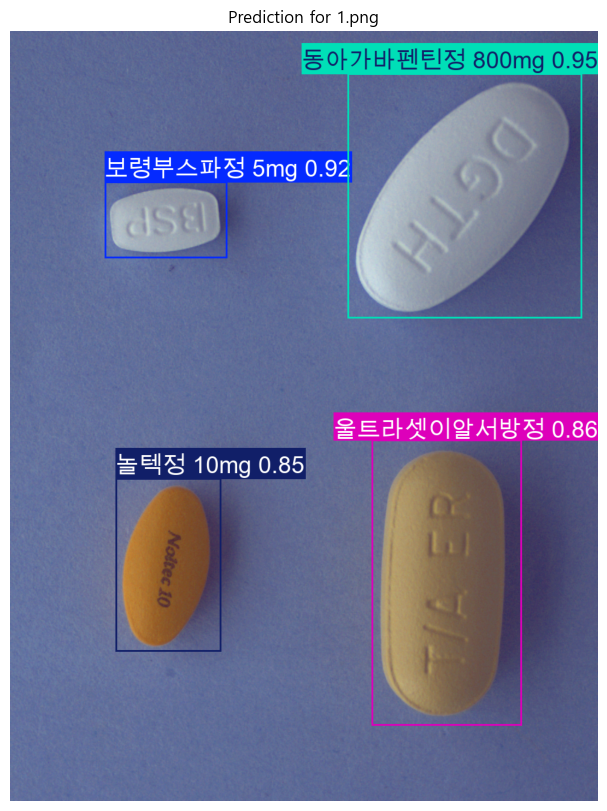

First image's detections:
  - Class: ÎèôÏïÑÍ∞ÄÎ∞îÌéúÌã¥Ï†ï 800mg (YOLO ID: 23), Conf: 0.95, Bbox (norm xywh): [0.7734133005142212, 0.21400824189186096, 0.3990876078605652, 0.31789737939834595]
  - Class: Î≥¥Î†πÎ∂ÄÏä§ÌååÏ†ï 5mg (YOLO ID: 0), Conf: 0.92, Bbox (norm xywh): [0.26536065340042114, 0.24543844163417816, 0.20742571353912354, 0.09874410927295685]
  - Class: Ïö∏Ìä∏ÎùºÏÖãÏù¥ÏïåÏÑúÎ∞©Ï†ï (YOLO ID: 51), Conf: 0.86, Bbox (norm xywh): [0.742484450340271, 0.7165263295173645, 0.25480926036834717, 0.37158986926078796]
  - Class: ÎÜÄÌÖçÏ†ï 10mg (YOLO ID: 44), Conf: 0.85, Bbox (norm xywh): [0.2698337137699127, 0.6931304335594177, 0.17953552305698395, 0.2248700112104416]


In [31]:
# Ï∂îÎ°† Í≤∞Í≥º ÏãúÍ∞ÅÌôî ÏòàÏãú
# inference_resultsÎäî Results Í∞ùÏ≤¥
if inference_results:
    print("Displaying first inference result (if available)...")
    first_result = inference_results[0]
    im_bgr = first_result.plot() # BGR Ïù¥ÎØ∏ÏßÄ (OpenCV ÌòïÏãù)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) # RGBÎ°ú Î≥ÄÌôò (matplotlibÏö©)

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(f"Prediction for {Path(first_result.path).name}")
    plt.axis('off')
    plt.show()

    # Î∞îÏö¥Îî© Î∞ïÏä§ Ï†ïÎ≥¥ Ï∂úÎ†• ÏòàÏãú
    print("First image's detections:")
    for box_data in first_result.boxes:
        cls = int(box_data.cls)
        conf = float(box_data.conf)
        xywh_norm = box_data.xywhn[0].tolist() # Ï†ïÍ∑úÌôîÎêú xywh

        # YOLO ÌÅ¥ÎûòÏä§ IDÎ•º Ïã§Ï†ú Ïπ¥ÌÖåÍ≥†Î¶¨ Ïù¥Î¶ÑÏúºÎ°ú Î≥ÄÌôò
        class_name = yolo_idx_to_name_map.get(cls, f"Unknown_{cls}")
        print(f"  - Class: {class_name} (YOLO ID: {cls}), Conf: {conf:.2f}, Bbox (norm xywh): {xywh_norm}")

In [32]:
# ====================================================================
# ÏûÑÏãú ÌååÏùº ÏÇ≠Ï†ú
# ====================================================================
shutil.rmtree(YOLO_LABELS_TEMP)
print(f"Removed temporary YOLO label directory: {YOLO_LABELS_TEMP}")

Removed temporary YOLO label directory: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp
